### Project Machine Learning, Multi-class Classification Problem: Geoscience example (Facies)

#### Jamal Hussain Shah 

In this project, we will implement standard and comprehensive steps to select the best model and hyperparameters to predict rock facies from a dataset. First, we will prepare data for modeling, fit the models and cross-validate, predict facies labels, and evaluate prediction accuracy by several model evaluation metrics. Finally, we will examine model performance on blind-well data. These are the models that we will use:<br>
1 - Logistic Regression Classifier <br>
2 - K Neighbors Classifier<br>
3 - Decision Tree Classifier<br>
4 - Random Forest Classifier<br>
5 - Support Vector Classifier<br>
6 - Gaussian Naive Bayes Classifier<br>
7 - Gradient Boosting Classifier<br>
8 - Extra Tree Classifier<br>

The dataset for this study comes from Hugoton and Panoma Fields in North America which was used as class exercise at The University of Kansas (Dubois et. al, 2007). It consists of log data(the measurement of physical properties of rocks) of nine wells. We will use these log data to train supervised classifiers in order to predict discrete facies groups. For more detail, you may take a look here. The seven features are:<br>

__GR__: this wireline logging tools measure gamma emission<br>
__ILD_log10__: this is resistivity measurement<br>
__PE__: photoelectric effect log<br>
__DeltaPHI__: Phi is a porosity index in petrophysics.<br>
__PNHIND__: Average of neutron and density log.<br>
__NM_M__:nonmarine-marine indicator<br>
__RELPOS__: relative position<br>

The nine discrete facies (classes of rocks) are:<br>
(SS) Nonmarine sandstone<br>
(CSiS) Nonmarine coarse siltstone<br>
(FSiS) Nonmarine fine siltstone<br>
(SiSH) Marine siltstone and shale<br>
(MS) Mudstone (limestone)<br>
(WS) Wackestone (limestone)<br>
(D) Dolomite<br>
(PS) Packstone-grainstone (limestone)<br>
(BS) Phylloid-algal bafflestone (limestone)<br>
For more detailand data explanation refer [here](https://github.com/mardani72/Facies-Classification-Machine-Learning/blob/master/Facies_Classification_Various_ML_Final.ipynb). <br>
The project content:

#### __1- Exploratory Data Analysis__
> 1-1 Data visualization 
>> 1-1-1 log-plot<br>
>> 1-1-2 Bar plot<br>
>> 1-1-3 Cross-plot<br>

> 1-2 Feature Engineering<br> 
>> 1-2-1 NaN imputation<br>
>> 1-2-2 Feature extraction<br>
>> 1-2-3 Oversampling<br>

> 1-3 Feature Importance<br> 
>> 1-3-1 Feature linear corrolation<br>
>> 1-3-2 Decision tree<br>
>> 1-3-3 Permutation feature importance<br>

#### __2- Build Model & Validate__
> 2-1 Baseline Model<br> 
> 2-2 Hyper-parameters
>> 2-2-1 Grid search<br>

#### __3- Model Evaluation-1__
> 3-1 Model Merices <br>
> 3-2 Confusion matrix <br>

#### __4- Model Evaluation-2__
> 4-1 Learning curves<br> 
> 4-2 ROC plot<br> 
> 4-3 Blind well prediction and evaluation<br> 

In [1]:
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import LabelEncoder
from collections import Counter
pd.set_option('display.max_rows', 30)
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('facies_vectors.csv')

In [3]:
# specify some data types may python concern about
df['Facies'] = df['Facies'].astype('int')
df['Depth'] = df['Depth'].astype('float')
df['Well Name'] = df['Well Name'].astype('category')

### 1-1 Data visualization 
#### 1-1-1 log-plot

In [4]:
# colors 
facies_colors = ['xkcd:goldenrod', 'xkcd:orange','xkcd:sienna','xkcd:violet',
       'xkcd:olive','xkcd:turquoise', "xkcd:yellowgreen", 'xkcd:indigo', 'xkcd:blue']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 
                 'MS',  'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
#establish facies label str    
df.loc[:,'FaciesLabels'] = df.apply(lambda row: label_facies(row, facies_labels), axis=1)

In [5]:
data=df

This is function to create a plot.

In [6]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 6))
    ax[0].plot(logs.GR, logs.Depth, '-g',  alpha=0.8, lw = 0.9)
    ax[1].plot(logs.ILD_log10, logs.Depth, '-b',  alpha=0.8, lw = 0.9)
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-k',  alpha=0.8, lw = 0.9)
    ax[3].plot(logs.PHIND, logs.Depth, '-r',  alpha=0.8, lw = 0.9)
    ax[4].plot(logs.PE, logs.Depth, '-c',  alpha=0.8, lw = 0.9)
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((5*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [7]:
data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

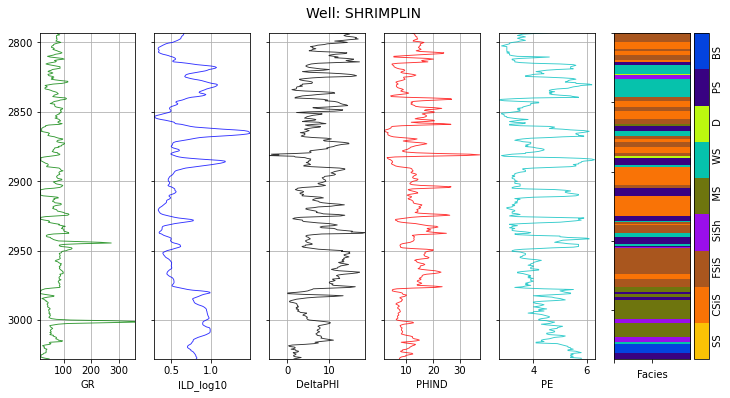

In [8]:
make_facies_log_plot(
    data[data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)
# plt.savefig("Well_example.png", dpi=400)

#### 1-1-2 Histogram

Let's facies percentages first:

In [9]:
cn = Counter(data.FaciesLabels)
for i,j in cn.items():
    percent = j / len(data) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (i, j, percent))

Class=FSiS, Count=780, Percentage=18.800%
Class=CSiS, Count=940, Percentage=22.656%
Class=PS, Count=686, Percentage=16.534%
Class=WS, Count=582, Percentage=14.027%
Class=D, Count=141, Percentage=3.398%
Class=SiSh, Count=271, Percentage=6.532%
Class=MS, Count=296, Percentage=7.134%
Class=BS, Count=185, Percentage=4.459%
Class=SS, Count=268, Percentage=6.459%


Text(0, 0.5, 'Frequency')

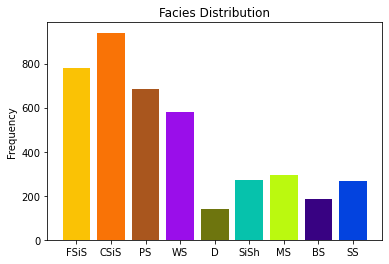

In [10]:
plt.bar(cn.keys(), cn.values(), color=facies_colors )
plt.title('Facies Distribution')
plt.ylabel('Frequency')
# plt.savefig("bar_plot.png", dpi=400)

This is imbalanced dataset. Dolomite has the lowest member participation. Comparing coarse siltstone, dolomite appears 8 times less than that.

#### 1-1-3 Cross-plot

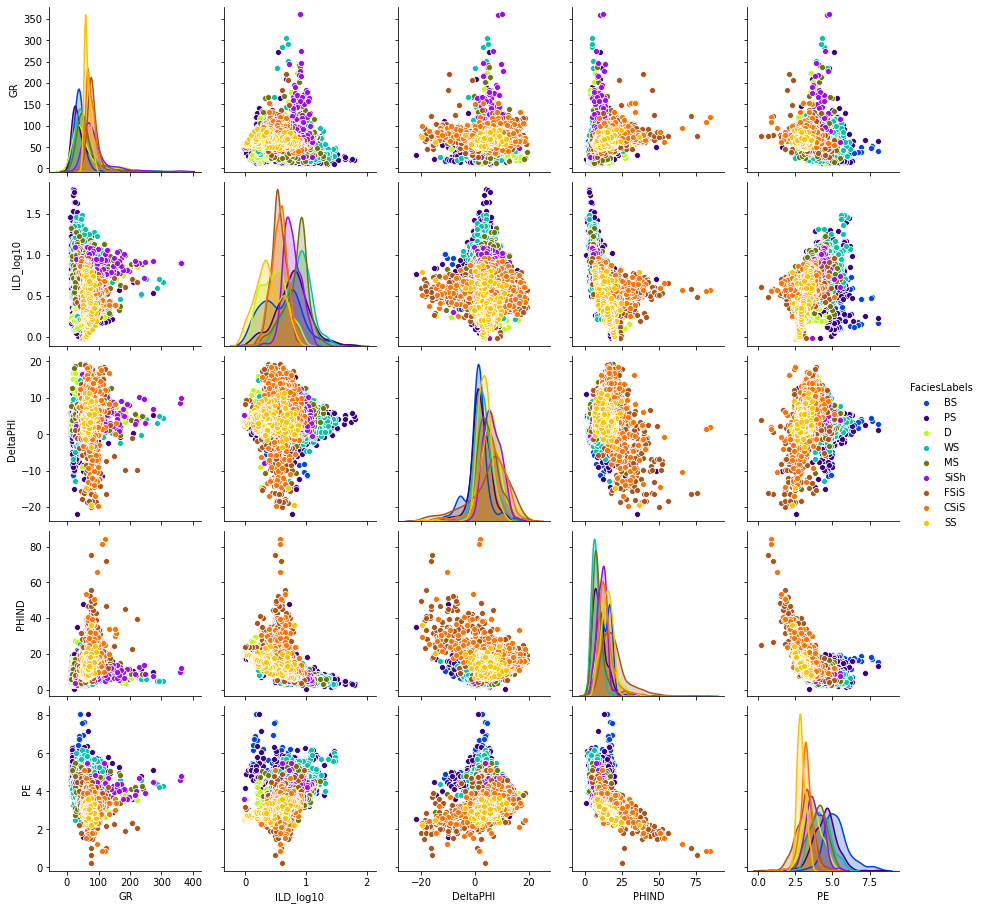

In [11]:
sns_plot = sns.pairplot(data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))
sns_plot.savefig('cross_plots.png')

##### Hereafter we will store dataset into new vriable after main operations (indented paragrpahs in introduction).

In [12]:
data_fe = data

#### 1-2 Feature Engineering 
##### 1-2-1 NaN imputation
Let's look at the data to see if Null values are present in dataset.

In [13]:
data_fe.isna().sum()

Facies            0
Formation         0
Well Name         0
Depth             0
GR                0
ILD_log10         0
DeltaPHI          0
PHIND             0
PE              917
NM_M              0
RELPOS            0
FaciesLabels      0
dtype: int64

In [14]:
# to find out which wells do not have PE
df_null = data_fe.loc[data_fe.PE.isna()]
df_null['Well Name'].unique()

[ALEXANDER D, KIMZEY A, Recruit F9]
Categories (3, object): [ALEXANDER D, KIMZEY A, Recruit F9]

There are several ways to deal with Null values in the dataset. The simplest approach is to drop the rows containing at least one null value. This can be logical with a bigger size dataset but with small-sized dataframes single points are important. We can impute null values with mean or from adjacent data points in columns. Filling with mean value will not affect data variance and therefore will not have an impact on prediction accuracy, though can create data bias. Another approach, which I will implement here, to employe machine learning models to predict missing values. This is the best way of dealing with this dataset because we have just a single feature missing from the dataset, PE. There is a meaningful correlation between this feature with others. 

In [15]:
data_fe.corr()

Facies     Depth        GR  ILD_log10  DeltaPHI     PHIND  \
Facies     1.000000  0.306688 -0.386677   0.383166 -0.235005 -0.356453   
Depth      0.306688  1.000000 -0.088636   0.202272  0.067694 -0.095834   
GR        -0.386677 -0.088636  1.000000  -0.205855  0.178863  0.270729   
ILD_log10  0.383166  0.202272 -0.205855   1.000000 -0.104827 -0.544416   
DeltaPHI  -0.235005  0.067694  0.178863  -0.104827  1.000000 -0.189355   
PHIND     -0.356453 -0.095834  0.270729  -0.544416 -0.189355  1.000000   
PE         0.704231  0.277577 -0.289023   0.384589  0.011489 -0.573418   
NM_M       0.852721  0.282318 -0.316284   0.493570 -0.177500 -0.481024   
RELPOS     0.076761  0.001537 -0.182051   0.088227  0.022470 -0.033328   

                 PE      NM_M    RELPOS  
Facies     0.704231  0.852721  0.076761  
Depth      0.277577  0.282318  0.001537  
GR        -0.289023 -0.316284 -0.182051  
ILD_log10  0.384589  0.493570  0.088227  
DeltaPHI   0.011489 -0.177500  0.022470  
PHIND     -0.573418 -0.481024 -0.033328  
PE         1.000000  0.657089  0.018905  
NM_M       0.657089  1.000000  0.034015  
RELPOS     0.018905  0.034015  1.000000

We can use various ML models to predict PE log as countinious regression problem. Here, I will employ Multi-Layer Percepteron Neural Network from scikit-learn to predict target value. I am not going to deep for this approach and use simply to predict missing values.

In [16]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [17]:
set_PE = data_fe[['Facies','Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']].dropna()  # select features and target log that has value
X = set_PE[['Facies','Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']]  # feature selection without null value
XX = data_fe[['Facies','Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']]
y = set_PE['PE'] # target log
# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_b = scaler.fit_transform(XX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
%%time
MLP_pe = MLPRegressor(random_state=1, max_iter= 500).fit(X_train, y_train) #fit the model
MLP_pe.score(X_test, y_test) # examine accuracy

Wall time: 34.9 s


C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.776094801295609

In [19]:
data_fe['PE_pred'] = MLP_pe.predict(X_b)  # predict PE
data_fe.PE.fillna(data_fe.PE_pred, inplace =True) # fill NaN vakues with predicted PE

###### Plot predecited PE

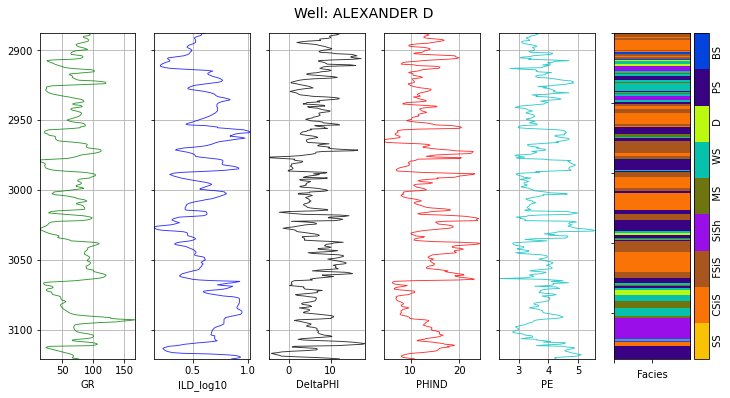

In [20]:
make_facies_log_plot(
    data[data['Well Name'] == 'ALEXANDER D'],
    facies_colors)
plt.savefig("predicted_PE.png", dpi=400)

In [21]:
# remove predicted PE column
data_fe = data_fe.drop(columns=['PE_pred'])
data = data.drop(columns=['PE_pred'])

#### 1-2-2 Feature extraction

Having limited set of features in this dataset can lead us to think about extracting some data from existing dataset.

First, we can convert formation categorical data into numeric data. Our background knowledge can help us to predict that some facies are possibly presnet more in a specififc formation rather than others.

In [22]:
# convert formation category data into numeric to use as predictor, add 1 starting from 1
data_fe['Formation_num'] = LabelEncoder().fit_transform(data_fe['Formation'].astype('str')) + 1

In [23]:
data_fe['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

#### Pick up a well as blind: 
machine learning algorithm will not see this data in the training process. We will use it at the end to see how the model works. Remember to select a well that includes all types of facies classes, otherwise in prediction, data dimension inconsistency will generate an error. Or simply add a lacking facies example to the well to avoid the problem.

In [24]:
blind = data_fe[data_fe['Well Name'] == 'KIMZEY A']
data_fe = data_fe[data_fe['Well Name'] != 'KIMZEY A']

To see if new feature extraction would assisst prediction improvment, we should define a baseline model then compare with extracted feature model.
##### Baseline Model Performance

In [25]:
X = data_fe[['Depth', 'GR', 'ILD_log10','DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'Formation_num']]
y = data_fe['Facies']

In [26]:
from numpy import mean
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

For simplicity we will use logistic regression classifier as baseline model and will examine model performance with cross validation concept. Data will be splitted into 10 subgroups and process will be reapeted 3 times.

In [27]:
model = LogisticRegression(solver='liblinear')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f' % (mean(scores)))

Accuracy: 0.573


Here, we can explore whether feature extraction can improve model performance. There are many approaches while we will use some transforms for chaining the distribution of the input variables such as Quantile Transformer and KBins Discretizer. Then, will remove linear dependencies between the input variables using PCA and TruncatedSVD.
To study more refer [here](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/).<br>
Using feature union class, we will define a list of transforms to perform results aggregated together. This will create a dataset with lots of feature columns while we need to reduce dimensionality to faster and better performance. Finally, Recursive Feature Elimination, or RFE, technique can be used to select the most relevant features. We select 30 features. 

In [28]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
#-------------------------------------------------- append transforms into a list
transforms = list()
transforms.append(('qt', QuantileTransformer(n_quantiles=100, output_distribution='normal')))
transforms.append(('kbd', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')))
transforms.append(('pca', PCA(n_components=7)))
transforms.append(('svd', TruncatedSVD(n_components=7)))
#-------------------------------------------------- initialize the feature union
fu = FeatureUnion(transforms)
#-------------------------------------------------- define the feature selection
rfe = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=30)
#-------------------------------------------------- define the model
model = LogisticRegression(solver='liblinear')
#-------------------------------------------------- use pipeline to chain operation
steps = list()
steps.append(('fu', fu))
steps.append(('rfe', rfe))
steps.append(('ml', model))
pipeline = Pipeline(steps=steps)
# define the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f' % (mean(scores)))

Accuracy: 0.614
Wall time: 53.5 s


Accuracy improvement shows that feature extraction can be useful approach when we are dealing with limited features in dataset.

#### 1-2-3 Oversampeling

In imbalanced datasets, we can use resampling technique to add some more data points to increase members of minority groups. This can be helpful whenever minority label targets has special importance such as credit card fraud detection. In that example, fraud can happen with less than 0.1 percent of transaction while it is important to detect fraud.<br>
In this work, we will add pseudo observation for Dolomite class which has the lowest poulation

__Synthetic Minority Oversampling Technique, SMOTE__: the technique is used to select the nearest neighbors in the feature space, separate examples by adding a line and producing new examples along the line. The method is not merely generating the duplicates from the outnumbered class, but applied K-nearest neighbours to generate synthetic data.

In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [30]:
X_sm1 , y_sm1 = smote.fit_sample(X,y)
X_sm , y_sm = X_sm1 , y_sm1  # keep for fuuture plotting an cimparision

In [31]:
print("Before SMOTE: ", Counter(y))
print("After SMOTE: ", Counter(y_sm))

Before SMOTE:  Counter({2: 855, 3: 706, 8: 596, 6: 531, 1: 259, 5: 243, 4: 228, 9: 178, 7: 114})
After SMOTE:  Counter({3: 855, 2: 855, 8: 855, 6: 855, 7: 855, 4: 855, 5: 855, 9: 855, 1: 855})


Now, dataset is balanced. Let's see how works comparing Baseline model:

In [32]:
scaler = StandardScaler()
X_sm = scaler.fit_transform(X_sm)

In [33]:
model_bal = LogisticRegression(solver='liblinear')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_bal, X_sm, y_sm, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f' % (mean(scores)))

Accuracy: 0.617


Accuracy improved by 3 percent but in multi-class classification, accuracy is not the best evaluation metrics. We will cover others in next parts.

In [34]:
data_fi = data

#### 1-3 Feature Importance
Some machine learning algorithms offer importance score to help the user to select the most efficient features for prediction.
##### 1-3-1 Feature linear corrolation

The concept is simple: features have higher correlation coefficient with target values are important for prediction. We can extract these coef's like: 

Feature: 0, Score: 0.00118
Feature: 1, Score: -0.00720
Feature: 2, Score: -0.41975
Feature: 3, Score: -0.03076
Feature: 4, Score: 0.05193
Feature: 5, Score: 0.93043
Feature: 6, Score: 3.39447
Feature: 7, Score: 0.32392
Feature: 8, Score: -0.01335


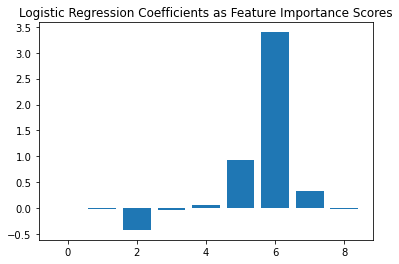

In [35]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Logistic Regression Coefficients as Feature Importance Scores')
pyplot.savefig('reg_importance.png')
pyplot.show()

##### 1-3-2 Decision tree
This algorithm provides importance scores based on the reduction in the criterion used to split in each node such as entropy or Gini.

Feature: 0, Score: 0.18977
Feature: 1, Score: 0.10361
Feature: 2, Score: 0.11184
Feature: 3, Score: 0.07300
Feature: 4, Score: 0.10601
Feature: 5, Score: 0.07828
Feature: 6, Score: 0.17064
Feature: 7, Score: 0.11668
Feature: 8, Score: 0.05017


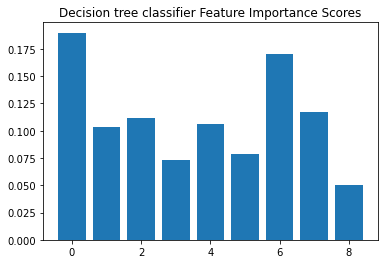

In [36]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Decision tree classifier Feature Importance Scores')
pyplot.savefig('DTree.png')
pyplot.show()

XGBoost is a library that provides an efficient and effective implementation of the stochastic gradient boosting algorithm. This algorithm can be used with scikit-learn via the XGBRegressor and XGBClassifier classes.

Feature: 0, Score: 0.03433
Feature: 1, Score: 0.03754
Feature: 2, Score: 0.03386
Feature: 3, Score: 0.02545
Feature: 4, Score: 0.04048
Feature: 5, Score: 0.04242
Feature: 6, Score: 0.69899
Feature: 7, Score: 0.03016
Feature: 8, Score: 0.05678


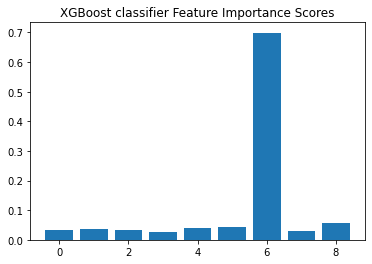

In [37]:
#pip install xgboost
from xgboost import XGBClassifier
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('XGBoost classifier Feature Importance Scores')
pyplot.show()

##### 1-3-3 Permutation feature importance

[Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.

Feature: 0, Score: -0.00199
Feature: 1, Score: 0.02604
Feature: 2, Score: 0.05677
Feature: 3, Score: 0.02534
Feature: 4, Score: 0.11639
Feature: 5, Score: 0.07978
Feature: 6, Score: 0.28318
Feature: 7, Score: 0.02992
Feature: 8, Score: 0.02712


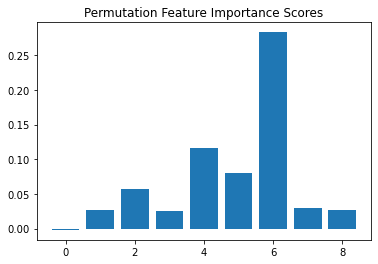

In [38]:
from sklearn.inspection import permutation_importance
model = LogisticRegression(solver='liblinear')
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.title('Permutation Feature Importance Scores')
pyplot.savefig('permu.png')
pyplot.show()

#### ^^^^^^^^^^^^^^^^^^^^^^^^^^^         End of Part 1        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### References:

1) https://jakevdp.github.io/PythonDataScienceHandbook/index.html <br>
2) https://scikit-learn.org/stable/supervised_learning.html#supervised-learning<br>
